# SMC2017: Exercise sheet IV

## Setup

In [1]:
import numpy as np
from scipy import stats
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## IV.1 Particle Metropolis-Hastings

Consider the state-space model
$$
\begin{array}{rcll}
x_t & = & \cos\left(\theta x_{t - 1}\right) + v_t, &\qquad v_t \sim \mathcal{N}(0, 1)\\
y_t & = & x_t + e_t, &\qquad e_t \sim \mathcal{N}(0, 1) \\
x_0 & \sim & \mathcal{N}(0, 1) &
\end{array}
$$
which admits the probabilistic model
$$
\begin{array}{lcl}
p(x_0) & = & \mathcal{N}\left(x_0;\,0,\,1\right) \\
p(x_t\,\big|\,x_{t - 1}) & = & \mathcal{N}\left(x_t;\,\cos\left(\theta x_{t - 1}\right),\,1\right) \\
p(y_t\,\big|\,x_t) & = & \mathcal{N}\left(y_t;\,x_t,\,1\right)
\end{array}
$$

For now, I will use the bootstrap particle filter (for simplicity).

### Simulate data

During the simulation $\theta = 1$ will be assumed. During the inference it will be assumed that $\theta \sim \mathcal{N}(0, 1)$.

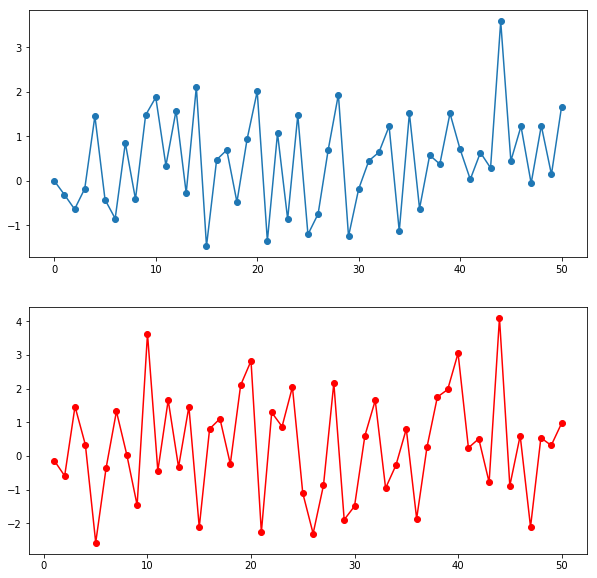

In [3]:
T = 50

xs_sim = np.zeros((T + 1,))
ys_sim = np.zeros((T,))

# Initial state
xs_sim[0] = 0.
for t in range(T):
    xs_sim[t + 1] = np.cos(xs_sim[t]) + stats.norm.rvs()
    
ys_sim = xs_sim[1:] + stats.norm.rvs(0, 1, T)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(xs_sim, 'o-')
axs[1].plot(range(1, T + 1), ys_sim, 'o-r')

Bootstrap particle filter giving an estimate $\widehat{z}_\theta$ of the joint likelihood $p(y_{1:T}\,\big|\,\theta)$.

In [44]:
def likelihood_bootstrap_pf(theta, y, N=20):
    # Cumulatively build up log-likelihood
    ll = 0.0
    # Initialisation
    samples = stats.norm.rvs(0, 1, N)
    weights = 1 / N * np.ones((N,))
    weights_normalized = weights
    
    # Determine the number of time steps
    T = len(y)
    # Loop through all time steps
    for t in range(T):
        # Resample
        # Randomly choose ancestors
        ancestors = np.random.choice(samples, size=N, 
                                     replace=True, p=weights_normalized)
        
        # Propagate
        samples = stats.norm.rvs(0, 1, N) + np.cos(theta * ancestors)
        
        # Weight
        weights = stats.norm.logpdf(y[t], loc=samples, scale=1)
        # Calculate the max of the weights
        max_weights = np.max(weights)
        # Subtract the max
        weights = weights - max_weights
        # Update log-likelihood
        ll += max_weights + np.log(np.sum(np.exp(weights))) - np.log(N)

        # Normalize weights to be probabilities
        weights_normalized = np.exp(weights) / np.sum(np.exp(weights))
  
    return ll

In [45]:
likelihood_bootstrap_pf(3, ys_sim, 50)

-94.167630129527879

As a proposal we can use $q(\theta'\,\big|\,\theta[k - 1]) = \mathcal{N}\left(\theta';\,\theta[k - 1], \tau\right)$ with an appropriately chosen $\tau$.

Implement a Metropolis-Hastings sampler with the above.

In [71]:
def particle_metropolis_hastings(M, y, tau=1):
    theta = np.zeros((M + 1,))
    alphas = np.zeros((M,))
    
    # Initial state
    theta[0] = 0
    # Iterate the chain
    for i in range(M):
        # Sample a new value
        theta_prop = stats.norm.rvs(theta[i], tau, 1)
        # Sample to be compared to the acceptance probability
        u = stats.uniform.rvs()
        # Terms in the second part of the acceptance probability
        # Proposal is symmetric, so terms containing the proposal will
        # cancel each other out
        num = likelihood_bootstrap_pf(theta_prop, y, N=50) + \
            stats.norm.logpdf(theta_prop)
        denom = likelihood_bootstrap_pf(theta[i], y, N=50) + \
            stats.norm.logpdf(theta[i])
        # Acceptance probability
        alpha = min(1, np.exp(num - denom))
        alphas[i] = alpha
        # Set next state depending on acceptance probability
        if u <= alpha:
            theta[i + 1] = theta_prop
        else:
            theta[i + 1] = theta[i]
            
    return theta, alphas

In [72]:
pars, alphas = particle_metropolis_hastings(2000, ys_sim)

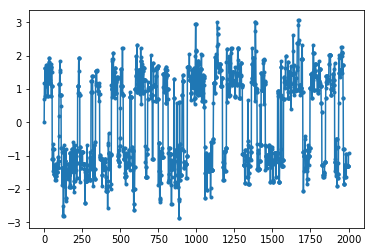

In [73]:
fig, ax = plt.subplots()
ax.plot(pars, '.-')

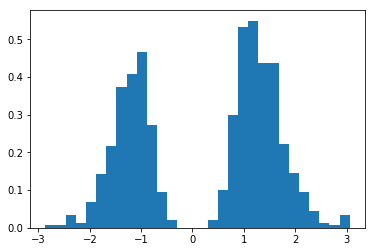

In [74]:
fig, ax = plt.subplots()
ax.hist(pars[500:], normed=True, bins=30);